In [1]:
# Local imports
import argparse
import glob
import os
import sys
import re

# Third-party imports
import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import cftime

In [2]:
# Import the dictionaries
import dictionaries as dic

# Import the functions
import processing_NAO_data as pnd
import functions_lag as fnc_lag
import functions_skill_maps as fnc_sm

In [3]:
# make the saved data directory if it doesn't exist
if not os.path.exists(dic.saved_data_dir):
    os.makedirs(dic.saved_data_dir)

# define the paths to the processed data files
azores_data_path = dic.azores_data_path
iceland_data_path = dic.iceland_data_path

In [4]:
# First thing to do is to process the observations
# We need to set up the parameters for this
forecast_range = "2-6"
season = "DJFM"
variable = "psl"
obs_var_name = "psl"
region_grid = "north-atlantic"
models = dic.models # all models for psl
observations_path = dic.full_era5 # contains all months and variables

In [5]:
# Check if the processed data files exist
if os.path.exists(azores_data_path) and os.path.exists(iceland_data_path):
    # If the files exist, load the processed data from the files
    obs_azores = xr.open_dataset(azores_data_path)
    obs_iceland = xr.open_dataset(iceland_data_path)
else:
    # If the files don't exist, process the observations and save the processed data to files
    # Process the observations for the Azores region
    region = "azores"
    obs_azores = fnc_sm.process_observations(variable, region, region_grid,
                                                forecast_range, season, 
                                                observations_path, obs_var_name)
    
    # Now do the same but for the iceland region
    region = "iceland"
    obs_iceland = fnc_sm.process_observations(variable, region, region_grid,
                                            forecast_range, season, 
                                            observations_path, obs_var_name)

    # Save the processed data to files
    # Save the processed data to files
    obs_azores.to_netcdf(azores_data_path)
    obs_iceland.to_netcdf(iceland_data_path)

In [6]:
obs_azores

<xarray.Dataset>
Dimensions:  (time: 65, lon: 4, lat: 2)
Coordinates:
  * time     (time) datetime64[ns] 1959-12-31 1960-12-31 ... 2023-12-31
  * lon      (lon) float64 -28.0 -25.5 -23.0 -20.5
  * lat      (lat) float64 36.0 38.5
Data variables:
    msl      (time, lat, lon) float64 ...

In [7]:
# Now we have obs anomaly fields for year 2-6 DJFM psl
# for both the azores and iceland gridboxes
# we want to take the fieldmean of these
# then subtract iceland from azores
# use the calculate_nao_index function from functions_skill_maps.py for this
obs_nao_index = fnc_sm.calculate_nao_index(obs_azores, obs_iceland)

In [8]:
obs_nao_index['msl'].values

array([            nan,             nan, -7.51649740e+02, -8.14930062e+02,
       -1.13847855e+03, -8.74938070e+02, -6.79720752e+02, -8.33128695e+02,
       -7.02208301e+02, -5.88570280e+02, -6.08759977e+02, -3.79148649e+02,
        1.15575895e+02,  2.62614453e+02,  4.47014990e+02,  1.72264518e+02,
       -1.42246257e+01, -3.10338151e+02, -3.84530257e+02, -4.38353988e+02,
       -2.12666797e+02, -2.14234375e+01,  2.63089176e+02,  1.63159408e+02,
        1.27120736e+02,  1.99257975e+01, -1.75619124e+02,  4.34665039e+01,
        3.96333740e+02,  4.61694076e+02,  6.70502490e+02,  8.69789925e+02,
        7.86404492e+02,  8.06675488e+02,  5.04092204e+02,  3.53599430e+02,
        1.69616895e+02,  9.45022624e+01, -3.70296224e-01,  6.48336426e+01,
        6.49379232e+01,  7.00361654e+01, -1.52084375e+02, -3.38177816e+02,
       -2.78532731e+02, -8.34730794e+01,  5.51780762e+01,  1.67432406e+02,
       -1.94191960e+02, -2.10536296e+02, -1.58270671e+02, -4.55658919e+02,
       -2.52919450e+02,  

In [9]:
obs_nao_index.time.values

array(['1959-12-31T00:00:00.000000000', '1960-12-31T00:00:00.000000000',
       '1961-12-31T00:00:00.000000000', '1962-12-31T00:00:00.000000000',
       '1963-12-31T00:00:00.000000000', '1964-12-31T00:00:00.000000000',
       '1965-12-31T00:00:00.000000000', '1966-12-31T00:00:00.000000000',
       '1967-12-31T00:00:00.000000000', '1968-12-31T00:00:00.000000000',
       '1969-12-31T00:00:00.000000000', '1970-12-31T00:00:00.000000000',
       '1971-12-31T00:00:00.000000000', '1972-12-31T00:00:00.000000000',
       '1973-12-31T00:00:00.000000000', '1974-12-31T00:00:00.000000000',
       '1975-12-31T00:00:00.000000000', '1976-12-31T00:00:00.000000000',
       '1977-12-31T00:00:00.000000000', '1978-12-31T00:00:00.000000000',
       '1979-12-31T00:00:00.000000000', '1980-12-31T00:00:00.000000000',
       '1981-12-31T00:00:00.000000000', '1982-12-31T00:00:00.000000000',
       '1983-12-31T00:00:00.000000000', '1984-12-31T00:00:00.000000000',
       '1985-12-31T00:00:00.000000000', '1986-12-31

In [10]:
# Now we want to load all of the same init files
# There should be 158 of them (we are missing CanESM5)
# These contain year 2-6 running means
# We will use them for our no lag case
# Set up the models to be included to be the no_CanESM5 models
models = dic.models_no_can

# Set up the base directory
base_dir = dic.base_directory

# Use the function: load_data_same_init from functions_lag.py
# to load the same init files
same_init_members = fnc_lag.load_data_same_init(base_dir, models, 
                                                variable, forecast_range, season)

Searching for files in  /home/users/benhutch/alternate-lag-processed-data/*BCC-CSM2-MR*same-init.nc
Files for BCC-CSM2-MR: ['/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r1i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r2i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r3i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r4i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r5i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r6i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r7i1.same-init.nc', '/home/users/benhutch/alternate-lag-processed-data/NAO_BCC-CSM2-MR_psl__DJFM_lag-4_r8i1.same-init.nc']
Searching for files in  /home/users/benhutch/alterna

In [11]:
# Now we want to process the same init model data before it is plotted
# by extracting the data for out variable of interest (e.g. temperature)
# and the time values
# the function used for this is: process_data from functions_lag.py
processed_same_init_members, same_init_members_time = fnc_lag.process_data(
    same_init_members, variable)

Dataset type: <class 'dict'>


In [12]:
# # test
# processed_same_init_members['NorCPM1']['psl'].values

all_ensemble_members_array shape (158, 54)
all_ensemble_members_array [[-2.2893238e-03  9.4505280e-01  6.0678750e-01 ... -2.2807882e+00
   8.3772004e-01  3.5866005e+00]
 [-1.1515179e+00 -8.1031090e-01 -3.7852185e+00 ...  6.8203044e-01
   3.1199975e+00 -2.9552474e+00]
 [-1.4741986e+00 -1.3700219e+00 -1.7187618e-01 ... -3.8500323e+00
  -1.5382730e+00 -4.8516445e+00]
 ...
 [ 2.3068366e+00 -1.7359596e+00 -1.8774229e+00 ... -4.5715728e-01
   3.2329491e-01 -2.5836933e+00]
 [ 4.3035111e+00 -1.4656928e-01  3.4950275e+00 ...  6.6801238e-01
  -6.5847945e-01 -7.4120179e-02]
 [ 3.3652642e+00  1.1717883e+00  1.7573901e+00 ...  2.3020625e+00
  -6.4180666e-01 -2.6108277e-01]]
grand ensemble mean shape (54,)
grand ensemble mean [-0.14511824 -0.37238035 -0.32333347 -0.7306603   0.3084617  -0.33716467
  0.17124096 -0.4884959   0.65640926  0.36391625 -0.15782078  0.24570683
 -0.17789592 -0.6296383  -0.5141685  -0.37504372 -0.1406241  -0.44136584
  0.003927    0.20823152 -0.05958697 -0.05823161  0.5425658

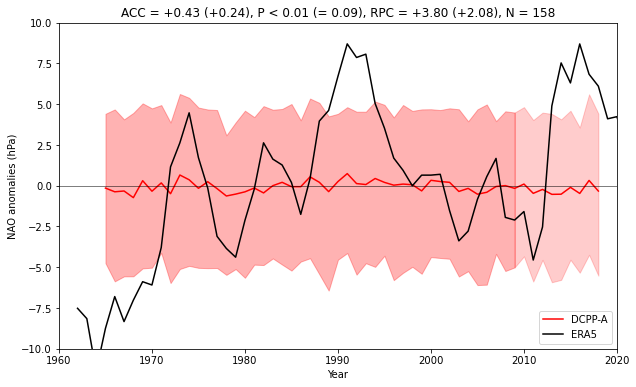

In [13]:
# Now we want to plot the no lag case for the 158 members
# Using the plot_ensemble_members_and_mean function
# from processing_NAO_data.py (pnd.)

# Set up the arguments for the function
models = dic.models_no_can
model_times = same_init_members_time
model_nao_anoms = processed_same_init_members
obs_nao_anom = obs_nao_index['msl'].values / 100
obs_time = obs_nao_index.time.values

# Run the function
pnd.plot_ensemble_members_and_mean(models, model_times, model_nao_anoms,
                                    obs_nao_anom, obs_time) 